# LGD Modeling (Loss Given Default) — End-to-End Starter Notebook

This notebook is a production-minded template for building an LGD model.
- Uses **synthetic lending-style data** so it runs offline.
- Swap in your real dataset by replacing the `make_synthetic_lgd_data()` cell.
- Focuses on: **cleaning, leakage checks, splits, baselines, Elastic Net, XGBoost-like GBM**, explainability, and monitoring hooks.


## 0) Setup

If you have these installed already, great:
- `numpy`, `pandas`, `scikit-learn`, `matplotlib`
- optional: `xgboost` and `shap`

This notebook will run without optional deps (it will skip those sections).


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def clipped_lgd(y):
    # LGD is typically bounded in [0, 1].
    return np.clip(y, 0.0, 1.0)


## 1) Create / Load Data

### Replace this section with your real LGD dataset

**Recommended schema (example):**
- `loan_amount`, `interest_rate`, `fico`, `dti`, `income`, `term_months`
- `purpose`, `state`, `channel`
- `months_on_book`, `delinq_12m`, `utilization`
- `recoveries` (or recovery cashflows) and `exposure_at_default` (EAD)

**Target:**
- `lgd = 1 - recovery_rate`, often `1 - (recoveries / EAD)`.


In [2]:
def make_synthetic_lgd_data(n=25000, random_state=42):
    rng = np.random.default_rng(random_state)

    purpose = rng.choice(
        ["debt_consolidation", "home_improvement", "medical", "vacation", "small_business", "other"],
        size=n,
        p=[0.45, 0.12, 0.07, 0.06, 0.05, 0.25],
    )
    state = rng.choice(["CA", "TX", "NY", "FL", "IL", "NJ", "GA", "PA", "OH", "NC", "OTHER"], size=n,
                       p=[0.13, 0.10, 0.08, 0.07, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03, 0.39])
    channel = rng.choice(["online", "branch", "partner"], size=n, p=[0.72, 0.18, 0.10])

    loan_amount = rng.lognormal(mean=np.log(12000), sigma=0.6, size=n)
    term_months = rng.choice([36, 60], size=n, p=[0.7, 0.3])
    fico = rng.normal(loc=690, scale=45, size=n).clip(520, 820)
    dti = rng.normal(loc=18, scale=8, size=n).clip(0, 55)
    income = rng.lognormal(mean=np.log(70000), sigma=0.55, size=n)
    utilization = rng.beta(a=2.2, b=3.8, size=n)  # 0..1
    delinq_12m = rng.poisson(lam=0.35, size=n).clip(0, 6)
    months_on_book = rng.integers(low=1, high=48, size=n)

    # Interest rate depends on risk factors
    base_rate = 0.09
    rate = (
        base_rate
        + 0.0008 * (720 - fico)  # lower fico -> higher rate
        + 0.0012 * (dti - 18).clip(-10, 25)
        + 0.06 * (utilization - 0.35).clip(-0.25, 0.65)
        + 0.01 * (delinq_12m > 0).astype(float)
        + rng.normal(0, 0.01, size=n)
    ).clip(0.03, 0.34)

    # True LGD signal (bounded 0..1), with nonlinearities and categorical effects
    purpose_effect = pd.Series(purpose).map({
        "debt_consolidation": 0.02,
        "home_improvement": -0.01,
        "medical": 0.03,
        "vacation": 0.01,
        "small_business": 0.06,
        "other": 0.00,
    }).values

    channel_effect = pd.Series(channel).map({
        "online": 0.00,
        "branch": -0.01,
        "partner": 0.02,
    }).values

    # Nonlinear risk components
    nonlinear = (
        0.12 * (utilization ** 1.8)
        + 0.08 * (np.maximum(0, (680 - fico)) / 200) ** 1.3
        + 0.04 * np.tanh((dti - 20) / 10)
        + 0.02 * (term_months == 60).astype(float)
        + 0.03 * (delinq_12m >= 2).astype(float)
        + 0.02 * np.sin(months_on_book / 6)
    )

    noise = rng.normal(0, 0.07, size=n)

    lgd = clipped_lgd(0.28 + nonlinear + purpose_effect + channel_effect + noise)

    df = pd.DataFrame({
        "loan_amount": loan_amount,
        "interest_rate": rate,
        "fico": fico,
        "dti": dti,
        "income": income,
        "term_months": term_months,
        "purpose": purpose,
        "state": state,
        "channel": channel,
        "utilization": utilization,
        "delinq_12m": delinq_12m,
        "months_on_book": months_on_book,
        "lgd": lgd,
    })

    # Add a few missing values to mimic real data
    for col in ["income", "dti", "utilization"]:
        mask = rng.random(n) < 0.02
        df.loc[mask, col] = np.nan

    return df

df = make_synthetic_lgd_data()
df.head()


,loan_amount,interest_rate,fico,dti,income,term_months,purpose,state,channel,utilization,delinq_12m,months_on_book,lgd
0,5537.893288,0.103720,676.867563,4.634562,71410.298675,36,other,OTHER,branch,0.053282,0,19,0.235691
1,13664.838799,0.192222,619.870823,19.328803,154670.709744,60,debt_consolidation,OTHER,online,0.315757,2,22,0.292504
2,17715.433456,0.081860,740.953802,23.936249,79965.228048,36,other,OTHER,online,0.354302,0,33,0.211938
3,9383.701964,0.109604,686.882093,10.660150,68199.492300,36,vacation,NJ,online,0.289096,1,46,0.538763
4,4880.733220,0.158190,638.770469,14.857832,80342.218127,36,debt_consolidation,PA,online,NaN,0,23,0.310049


## 2) Quick EDA & Sanity Checks

- LGD should be in [0, 1]
- Watch out for **leakage**: any variable that is only known *after* default or collections (e.g., recoveries, disposition codes, post-chargeoff balances)


In [3]:
df.describe(include="all").transpose().head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amount,25000.0,NaN,NaN,NaN,14302.8793,9531.841762,1164.185123,7945.440214,11882.67296,17913.779171,179280.951626
interest_rate,25000.0,NaN,NaN,NaN,0.118766,0.039942,0.03,0.091475,0.118533,0.145611,0.290905
fico,25000.0,NaN,NaN,NaN,689.87754,45.161178,520.0,659.448773,689.616957,720.379218,820.0
dti,24507.0,NaN,NaN,NaN,18.092981,7.904948,0.0,12.686447,18.069102,23.442992,55.0
income,24503.0,NaN,NaN,NaN,81672.840283,49076.714143,8566.185673,48322.548027,70408.568068,101987.522234,1090942.311349
term_months,25000.0,NaN,NaN,NaN,43.23456,11.013421,36.0,36.0,36.0,60.0,60.0
purpose,25000,6,debt_consolidation,11233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,25000,11,OTHER,9817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel,25000,3,online,18022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
utilization,24464.0,NaN,NaN,NaN,0.365803,0.181242,0.006083,0.22536,0.349964,0.490452,0.96468


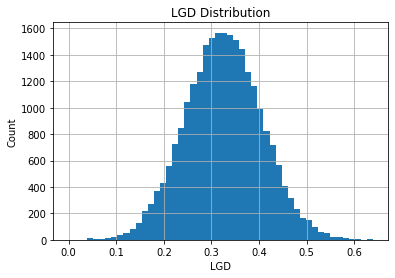

(0.0, 0.6395749297041771)

In [4]:
# Target distribution
plt.figure()
df["lgd"].hist(bins=50)
plt.title("LGD Distribution")
plt.xlabel("LGD")
plt.ylabel("Count")
plt.show()

df["lgd"].min(), df["lgd"].max()


## 3) Train/Test Split

For real lending data, prefer:
- **Time-based split** if you have origination / default dates (train on past, test on future)
- Otherwise random split is okay for this template


In [5]:
target = "lgd"
X = df.drop(columns=[target])
y = df[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

num_cols, cat_cols


(['loan_amount',
  'interest_rate',
  'fico',
  'dti',
  'income',
  'term_months',
  'utilization',
  'delinq_12m',
  'months_on_book'],
 ['purpose', 'state', 'channel'])

## 4) Preprocessing Pipeline

- Impute missing values
- One-hot encode categoricals
- Standardize numeric features for linear models (Elastic Net)


In [6]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


## 5) Baseline Models

We’ll run:
1) **OLS baseline** (LinearRegression)  
2) **Elastic Net** (regularized linear model)  
3) **Histogram GBM** (fast tree-based regressor built into sklearn)

Metrics:
- MAE (easy to interpret)
- RMSE (penalizes large errors)
- R² (less important, but included)


In [7]:
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred_tr = clipped_lgd(model.predict(X_tr))
    pred_te = clipped_lgd(model.predict(X_te))

    out = {
        "model": name,
        "train_mae": float(mean_absolute_error(y_tr, pred_tr)),
        "test_mae": float(mean_absolute_error(y_te, pred_te)),
        "train_rmse": rmse(y_tr, pred_tr),
        "test_rmse": rmse(y_te, pred_te),
        "train_r2": float(r2_score(y_tr, pred_tr)),
        "test_r2": float(r2_score(y_te, pred_te)),
    }
    return out, pred_te

results = []
preds = {}

# 1) OLS baseline
ols = Pipeline(steps=[("prep", preprocess), ("model", LinearRegression())])
out, p = eval_model("OLS", ols, X_train, y_train, X_test, y_test)
results.append(out); preds["OLS"] = p

# 2) Elastic Net (start with reasonable defaults)
enet = Pipeline(steps=[("prep", preprocess), ("model", ElasticNet(alpha=0.01, l1_ratio=0.25, random_state=RANDOM_STATE))])
out, p = eval_model("ElasticNet", enet, X_train, y_train, X_test, y_test)
results.append(out); preds["ElasticNet"] = p

# 3) Tree-based baseline (no scaling needed but reuse preprocess for OHE + impute)
hgb = Pipeline(steps=[("prep", preprocess), ("model", HistGradientBoostingRegressor(
    learning_rate=0.08,
    max_depth=6,
    max_bins=255,
    random_state=RANDOM_STATE
))])
out, p = eval_model("HistGB", hgb, X_train, y_train, X_test, y_test)
results.append(out); preds["HistGB"] = p

pd.DataFrame(results).sort_values("test_mae")


,model,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2
2,HistGB,0.053720,0.056756,0.067433,0.071069,0.291983,0.194560
0,OLS,0.057465,0.057289,0.072127,0.071793,0.189989,0.178074
1,ElasticNet,0.059049,0.058777,0.074113,0.073588,0.144753,0.136451


## 6) Residual Analysis

Look for:
- Systematic bias in certain ranges (e.g., underpredicting high LGD)
- Heteroscedasticity patterns
- Segment-specific residuals (purpose/state/channel)


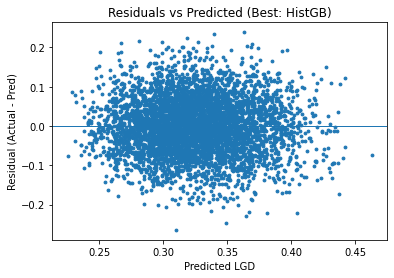

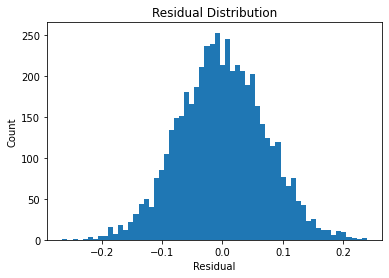

In [8]:
# Choose the best model by test MAE
best_name = pd.DataFrame(results).sort_values("test_mae").iloc[0]["model"]
best_pred = preds[best_name]

resid = y_test.values - best_pred

plt.figure()
plt.scatter(best_pred, resid, s=8)
plt.axhline(0, linewidth=1)
plt.title(f"Residuals vs Predicted (Best: {best_name})")
plt.xlabel("Predicted LGD")
plt.ylabel("Residual (Actual - Pred)")
plt.show()

plt.figure()
plt.hist(resid, bins=60)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


## 7) Segment Performance (Business-Relevant)

In lending, it’s common to report model error by segment, e.g.:
- purpose
- state
- channel
- FICO band / DTI band


In [9]:
eval_df = X_test.copy()
eval_df["actual_lgd"] = y_test.values
eval_df["pred_lgd"] = best_pred
eval_df["abs_err"] = np.abs(eval_df["actual_lgd"] - eval_df["pred_lgd"])

# FICO bands
eval_df["fico_band"] = pd.cut(eval_df["fico"], bins=[520, 620, 660, 700, 740, 820], include_lowest=True)

seg = (
    eval_df.groupby(["fico_band", "purpose"], observed=True)
    .agg(n=("abs_err","size"), mae=("abs_err","mean"), avg_actual=("actual_lgd","mean"), avg_pred=("pred_lgd","mean"))
    .reset_index()
    .sort_values(["fico_band","mae"], ascending=[True, False])
)

seg.head(15)


,fico_band,purpose,n,mae,avg_actual,avg_pred
5,"(519.999, 620.0]",vacation,21,0.064314,0.343885,0.333434
0,"(519.999, 620.0]",debt_consolidation,131,0.062849,0.345798,0.354302
1,"(519.999, 620.0]",home_improvement,43,0.062236,0.332029,0.329597
3,"(519.999, 620.0]",other,64,0.053935,0.329381,0.331841
4,"(519.999, 620.0]",small_business,13,0.052838,0.374453,0.382006
2,"(519.999, 620.0]",medical,18,0.039439,0.366252,0.352962
11,"(620.0, 660.0]",vacation,66,0.066692,0.314388,0.321530
8,"(620.0, 660.0]",medical,65,0.064479,0.357573,0.348262
10,"(620.0, 660.0]",small_business,41,0.059397,0.368004,0.371452
6,"(620.0, 660.0]",debt_consolidation,435,0.055141,0.334683,0.335582


## 8) Explainability (Optional)

If you have `shap` installed, you can compute SHAP values for the tree model.
For linear models, coefficient inspection is also useful.


In [10]:
# Linear model coefficient view (ElasticNet), if you want
# We need feature names from the preprocessor
def get_feature_names(preprocessor, num_cols, cat_cols):
    # numeric names pass-through
    num_features = num_cols
    # categorical onehot names
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

# Fit ElasticNet explicitly for coefficient extraction
enet.fit(X_train, y_train)

prep_fitted = enet.named_steps["prep"]
feature_names = get_feature_names(prep_fitted, num_cols, cat_cols)

coefs = enet.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

coef_df.head(15), coef_df.tail(15)


(                       feature      coef
 3                          dti  0.018222
 6                  utilization  0.013809
 5                  term_months  0.005912
 1                interest_rate  0.004219
 7                   delinq_12m  0.001471
 4                       income -0.000000
 2                         fico -0.000000
 0                  loan_amount  0.000000
 9   purpose_debt_consolidation  0.000000
 11             purpose_medical  0.000000
 15                    state_CA -0.000000
 14            purpose_vacation -0.000000
 13      purpose_small_business  0.000000
 21                    state_NY -0.000000
 22                    state_OH -0.000000,
                      feature      coef
 22                  state_OH -0.000000
 23               state_OTHER  0.000000
 16                  state_FL -0.000000
 17                  state_GA -0.000000
 18                  state_IL -0.000000
 19                  state_NC  0.000000
 20                  state_NJ  0.000000
 25    

<Figure size 432x288 with 0 Axes>

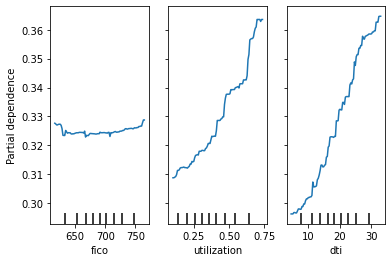

In [11]:
# Partial Dependence example (works for tree model)
# Fit tree model for PDP
hgb.fit(X_train, y_train)

features_for_pdp = ["fico", "utilization", "dti"]
plt.figure()
PartialDependenceDisplay.from_estimator(hgb, X_test, features_for_pdp)
plt.show()


## 9) Monitoring Hooks (What you'd productionize)

Track over time (weekly/monthly):
- Input drift (PSI / KS) for key features (fico, dti, utilization, purpose mix)
- Prediction drift (mean/quantiles of predicted LGD)
- Error drift (MAE/RMSE on recent labeled outcomes)
- Segment drift (by channel/state/purpose)
- Data quality checks (missingness, outliers)

Below is a small PSI helper to get you started.


In [12]:
def psi(expected, actual, buckets=10, eps=1e-6):
    # expected: reference distribution (train), actual: current distribution (test / new)
    expected = pd.Series(expected).dropna()
    actual = pd.Series(actual).dropna()

    quantiles = np.linspace(0, 1, buckets + 1)
    breakpoints = expected.quantile(quantiles).values
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    exp_counts = pd.cut(expected, bins=breakpoints).value_counts().sort_index()
    act_counts = pd.cut(actual, bins=breakpoints).value_counts().sort_index()

    exp_perc = (exp_counts / exp_counts.sum()).clip(eps, 1)
    act_perc = (act_counts / act_counts.sum()).clip(eps, 1)

    return float(((act_perc - exp_perc) * np.log(act_perc / exp_perc)).sum())

# Example: PSI for fico between train and test
psi_fico = psi(X_train["fico"], X_test["fico"])
psi_util = psi(X_train["utilization"], X_test["utilization"])
psi_dti = psi(X_train["dti"], X_test["dti"])

psi_fico, psi_util, psi_dti


(0.0021107078899886395, 0.0012498135271682277, 0.0013024329403257106)

## 10) Next Steps (Upgrade to Your Real Data)

1) Replace synthetic generator with your dataset load
2) Ensure you compute LGD correctly (recoveries / EAD), with correct timing
3) Use a **time split** (train on older defaults, test on newer defaults)
4) Add **cost-weighted metrics** (higher penalty for large LGD underestimation)
5) Add **calibration** if using probabilities / combining PD×LGD
6) Create a governance doc: assumptions, limitations, monitoring, fairness
